In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
from math import sqrt

#plots
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# for vectorization 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# similarity/distance measures
from scipy.spatial import distance
from sklearn.metrics.pairwise import linear_kernel

# sklearn
from sklearn.svm import LinearSVC
from sklearn.exceptions import DataConversionWarning; import warnings
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet, LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import GridSearchCV

# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image

import seaborn as sns

from datetime import datetime
import matplotlib.dates as mdate

from gensim.models import Word2Vec

In [2]:
# load data
data = pd.read_csv('processed_data2.csv')
#data = data.dropna()
data = data.reset_index()

In [3]:
# load minimized data
data_min = pd.read_csv('no_words2.csv')

#### Descriptive summary/ statistics

In [4]:
# Original data
data['comments'].describe()

count    26188.000000
mean       108.739003
std        199.615174
min          0.000000
25%          9.000000
50%         37.000000
75%        115.000000
max       2676.000000
Name: comments, dtype: float64

In [5]:
# Minimized data
data_min['comments'].describe()

count    6471.000000
mean      107.864318
std       196.531814
min         0.000000
25%        10.000000
50%        38.000000
75%       116.000000
max      2596.000000
Name: comments, dtype: float64

#### Plot distribution 

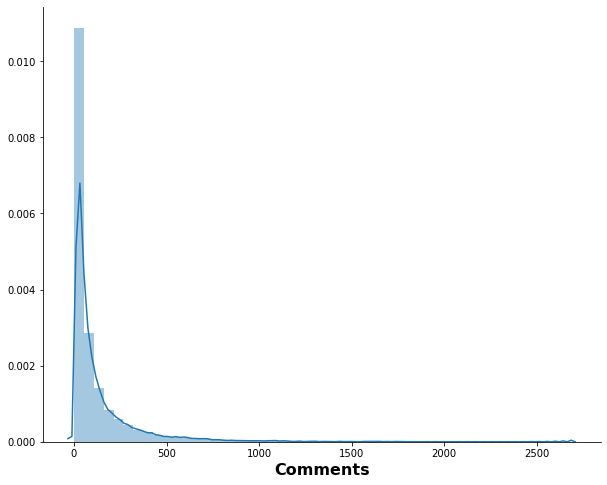

In [6]:
fig, ax = plt.subplots(figsize = (10,8))
sns.distplot(data['comments'])
ax = plt.gca()
ax.set_xlabel('Comments', weight='bold')
ax.xaxis.label.set_fontsize(16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

#### Missing URLS

In [7]:
# Translating months into english and remove punctions for formatting
data['date'] = [i.replace('.','').replace('maj','may').replace('okt','oct') for i in data['date']]
# Formatting dates
data['date'] = pd.to_datetime(data['date'], format = '%d %b %Y')

In [8]:
x1 = np.asarray(data['date']).astype(float) # Matplotlib has issues with autoscaling. Converting to epoch time instead :https://github.com/matplotlib/matplotlib/issues/7413

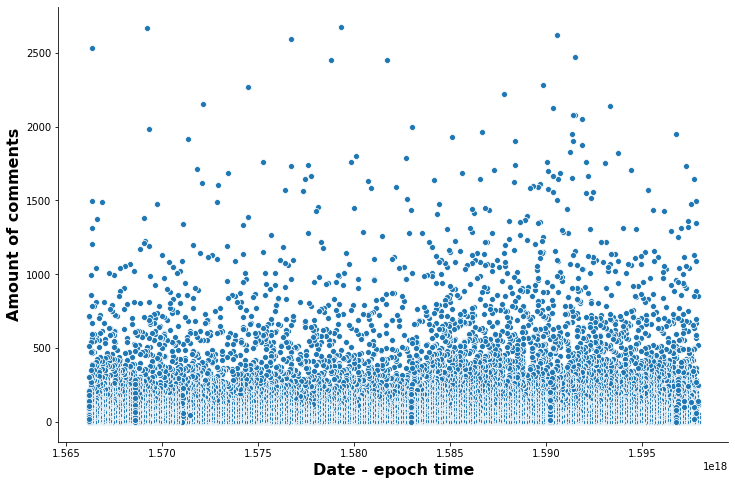

In [9]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.scatterplot(x=x1, y='comments', data=data) 
ax = plt.gca()
ax.set_xlabel('Date - epoch time', weight='bold')
ax.set_ylabel('Amount of comments', weight='bold')
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### Aggregating weekly comments and plot

In [10]:
data_agg = data.copy()

In [11]:
data_agg = data.set_index('date')

In [12]:
data_agg.index = pd.to_datetime(data_agg.index, unit='s')

In [13]:
weekly = data_agg.resample('W').sum()

In [14]:
weekly['date'] = weekly.index.get_level_values('date')

In [15]:
x = np.asarray(weekly['date']).astype(float) # Matplotlib has issues with autoscaling. Converting to epoch time instead :https://github.com/matplotlib/matplotlib/issues/7413

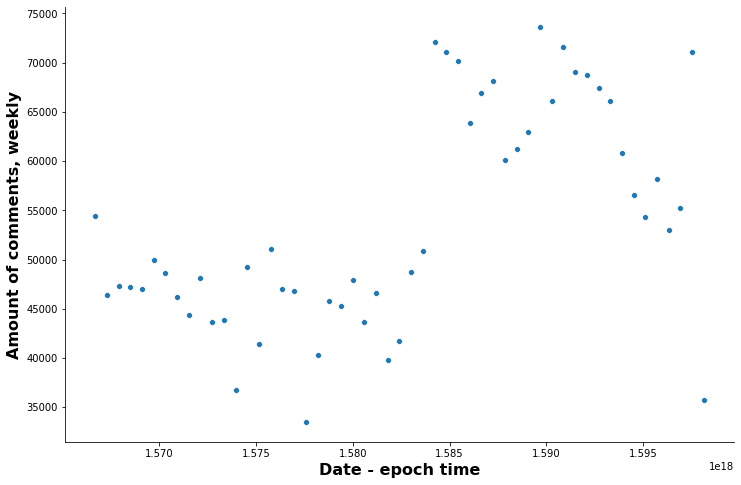

In [17]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.scatterplot(x=x, y='comments', data=weekly) 
ax = plt.gca()
ax.set_xlabel('Date - epoch time', weight='bold')
ax.set_ylabel('Amount of comments, weekly', weight='bold')
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#### PCA

In [18]:
data_value_count = data['title'].str.split(expand=True).stack().value_counts().reset_index()

In [19]:
data_split = [sent.split(' ') for sent in data['title']]

In [20]:
from gensim.models import Word2Vec

model = Word2Vec(data_split, size=100, min_count = 0, workers = 2) 

In [21]:
for i, word in enumerate(model.wv.vocab):
    if i == 100:
        break
    print(word)

Statsministeren
åbner
for
muligt
påbud
om
mundbind
Mette
F.
afviser
at
åbne
nattelivet
i
august
Dårligt
nyt
til
'Venner'-fans
Flemming
dødtræt
af
Elgiganten:
Gør
det
aldrig!
Venstre
vil
have
håndtrykket
tilbage,
hvis
kan
lade
sig
gøre
Bizar
opladning:
Derfor
smører
han
ind
babyolie
Når
du
ikke
betaler
regningen
Nye
coronatiltag:
-
Føles
grænseoverskridende
Så
farlige
er
hestehuller
Årets
bedste
Lundgaard:
Undskyld,
gutter
Toprådgiver
flere
amerikanske
præsidenter
død
Børn
op
12
år
og
visse
ældre
skal
bruge
Feriepengene
udbetales
oktober
Parken
forventer
gigantisk
underskud

Skuespiller
smittet
med
coronavirus:
'Troede
jeg
skulle
dø'
Skoleskibet
Danmark
har
en
elev
coronavirus
Giro-vinder
sejrede


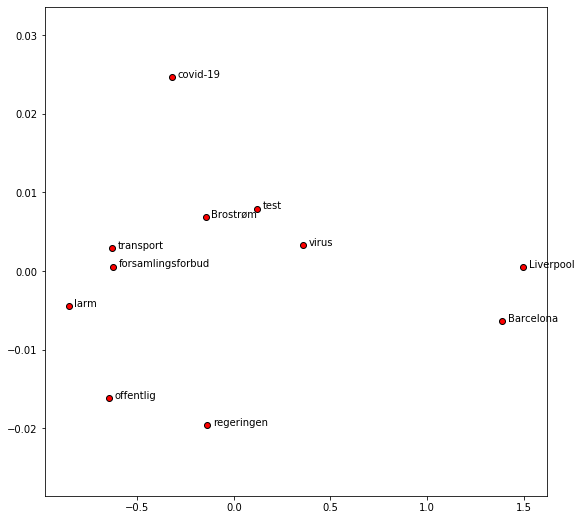

In [22]:
# Reducing the 50-dimensional vectors to 2 dimensions in order to visualise selected words.
from sklearn.decomposition import PCA

words = ["virus", 'forsamlingsforbud', 'regeringen', 'Barcelona', 'Brostrøm', 'covid-19','transport', 'offentlig','test','larm','Liverpool']

model_list_wv = []
for word in words:
    model_ = model.wv[word]
    model_list_wv.append(model_)
X = model_list_wv
# X = [model.wv['Corona'], model.wv['Tyskland'], 
#      model.wv['Dansk'], model.wv['kroner'],
#      model.wv['Trump'], model.wv['Svensk'], 
#      model.wv['millioner'], model.wv['smittet']]

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(figsize=(9,9) )
plt.scatter(X_r[:,0], X_r[:,1], edgecolors='k', c='r' )
for word, (x,y) in zip(words, X_r):
    plt.text(x+0.03, y+0.000005, word)